### Load Libraries and Set Parameters 

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from helpers import create_csv_submission
from helpers import load_csv_data
from itertools import combinations, combinations_with_replacement

# Define wheteher one hot encoding, PCA, polynomial basis expansion, data augmentation should be done 
perform_one_hot = True  
perform_pca = True
perform_pbe = False
perform_data_aug = False 

train_file_name = "data/dataset/X_train_pca_ohe.csv"
test_file_name = "data/dataset/X_test_pca_ohe.csv"

### Functions to load data

In [2]:
def load_data(CSV_PATH):
    
    """
    Load data from CSV file path 
    Returns : data and headers (feature names)
    """
    
    # read headers
    with open(CSV_PATH, 'r') as file:
        reader = csv.reader(file)
        feature_names = next(reader)

    # load numeric data (skip header row)
    X = np.genfromtxt(
        CSV_PATH,
        delimiter=",",
        skip_header=1,
        dtype=float,
    )
    
    return X, feature_names

### Functions for missingness analysis

In [3]:
def plot_missingness(X):
    
    """
    Generate plot displaying number of features with at most x% missing data in matrix X 
    """
    
    # 3) compute % missing
    missing_pct = np.isnan(X).mean(axis=0) * 100
    thresholds = np.arange(0, 101, 5)
    feature_counts = [(missing_pct <= threshold).sum() for threshold in thresholds]

    plt.figure(figsize=(10, 6))
    plt.bar(thresholds, feature_counts, color='b', width=4)
    plt.xlabel('Threshold % of missing data')
    plt.ylabel('Number of features with at most x% missing data')
    plt.title('Number of features with at most x% missing data')
    plt.xticks(thresholds)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("plot.png", dpi=300)
    plt.show()
    
    return 

def compute_missing(X, feature_names,threshold_percent):
    
    """
    Keep columns whose NaN% ≤ threshold.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Numeric matrix with missing values as np.nan.
    feature_names : Sequence[str]
        Names for each column of X (len == n_features).
    threshold_percent : float
        Max allowed percent (0–100) of NaNs to keep a column.

    Returns
    -------
    X_rem_missing : np.ndarray
        X with only columns meeting the missingness threshold.
    feature_names_rem_missing : list[str]
        Names corresponding to the kept columns, in order.
    """
    
    # keep features with ≤ threshold % missing
    missing_pct = np.isnan(X).mean(axis=0) * 100
    mask_threshold = missing_pct <= threshold_percent
    X_rem_missing = X[:, mask_threshold]
    feature_names_rem_missing = [name for i, name in enumerate(feature_names) if mask_threshold[i]]

    return X_rem_missing, feature_names_rem_missing

def remove_cols(X, feature_names, cols_to_remove):
    
    """
    Drop columns by name and report what remains.

    Parameters
    ----------
    X : np.ndarray, shape (n_samples, n_features)
        Feature matrix.
    feature_names : Sequence[str]
        Column names for X.
    cols_to_remove : Collection[str]
        Names of columns to delete; non-matches are ignored.

    Returns
    -------
    X_reduced : np.ndarray
        X with the listed columns removed.
    feature_names_reduced : list[str]
        Names of the remaining columns, in order.
    """
    
    remove_idx = [i for i, name in enumerate(feature_names) if name in cols_to_remove]
    X_reduced = np.delete(X, remove_idx, axis=1)
    feature_names_reduced = [name for i, name in enumerate(feature_names) if i not in remove_idx]

    print("Final shape:", X_reduced.shape)
    print("Remaining features:", len(feature_names_reduced))
    print("kept features:", feature_names_reduced)

    return X_reduced, feature_names_reduced

### Functions to 

In [4]:
def apply_semantics(col, name):
    """
    Map special "None" codes to zero for a given feature.

    If `name` exists as a key in the global mapping `SPECIAL_TO_ZERO`, this
    function interprets the corresponding code as representing "none"/"not
    applicable" and converts those entries in `col` to `0.0`.

    Parameters
    ----------
    col : array-like
        1D column; will be float-cast if a mapping is applied.
    name : str
        Feature name used to look up the code in SPECIAL_TO_ZERO.

    Returns
    -------
    col : array-like
        Same shape as input; with matched code values replaced by 0.0,
        otherwise unchanged.
    
    Notes
    -----
    - Uses a global dict `SPECIAL_TO_ZERO` mapping feature names to the code
      value that should be interpreted as zero.
    - When a mapping is applied, the column is cast to `float` (`astype(float, copy=True)`).
    - If casting to float is not possible (e.g., non-numeric strings), a
      `ValueError` may be raised by NumPy.
    """
    
    code = SPECIAL_TO_ZERO.get(name)
    if code is not None:
        col = col.astype(float, copy=True)
        col[col == float(code)] = 0.0
    return col

def apply_missing_codes(col, name):
    """
    Replace feature-specific coded missings with NaN.

    Globals
    -------
    DEFAULT_MISS : Sequence[float|int]
        Generic codes treated as missing for all features (e.g., -9, 9999).
    SPECIAL_MISS : dict[str, Sequence[float|int]]
        Per-feature overrides; if `name` is a key, its codes replace DEFAULT_MISS.

    Parameters
    ----------
    col : array-like
        1D column; cast to float internally before comparison.
    name : str
        Feature name used to select codes from SPECIAL_MISS, else DEFAULT_MISS.

    Returns
    -------
    col : np.ndarray
        Float array with any matching codes set to np.nan.
    """
    col = col.astype(float, copy=True)
    codes = np.array(SPECIAL_MISS.get(name, DEFAULT_MISS), dtype=float)
    if codes.size:
        col[np.isin(col, codes)] = np.nan
    return col

def clean_data(X_reduced,feature_names_reduced):
    """
    Apply missing-code mapping and semantics to each column.

    For each feature, first converts special missing codes to NaN
    (apply_missing_codes), then maps special "none" codes to 0.0
    (apply_semantics).

    Parameters
    ----------
    X_reduced : np.ndarray, shape (n_samples, n_features)
        Numeric matrix to clean.
    feature_names_reduced : Sequence[str]
        Column names aligned with X_reduced.

    Returns
    -------
    X_reduced : np.ndarray
        Cleaned matrix (modified in place and also returned).
    """
    for j, name in enumerate(feature_names_reduced):
        col = X_reduced[:, j]
        col = apply_missing_codes(col, name)
        col = apply_semantics(col, name)
        X_reduced[:, j] = col
    
    return X_reduced


### Functions for imputation

In [5]:
def plot_unique_counts(
    X, feature_names,
    top_n=None,               # e.g., 50 to show top 50 by uniqueness; None = all
    sort_desc=True,           # sort by unique count
    filename="unique_counts.png"
):
    
    """
    Plot and report the number of unique (non-NaN) values per column.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Data matrix; cast to float internally (NaNs expected for missing).
    feature_names : Sequence[str]
        Column names aligned with X.
    top_n : int or None, optional
        If set, show only the top N columns by unique count.
    sort_desc : bool, optional
        If True, sort columns by unique count (descending).
    filename : str, optional
        Where to save the bar chart image (PNG).

    Returns
    -------
    uniq_counts : np.ndarray, shape (n_features,)
        Count of unique non-NaN values for each column (unsorted original order).
    prop_unique : np.ndarray, shape (n_features,)
        Proportion of unique values among non-missing for each column.

    Notes
    -----
    - Saves a horizontal bar chart to `filename` and displays it.
    - Also prints a small console table for quick inspection.
    """
    
    X = np.asarray(X, dtype=float)
    n, p = X.shape

    uniq_counts = []
    prop_unique = []
    for j in range(p):
        col = X[:, j]
        v = col[~np.isnan(col)]
        k = np.unique(v).size
        uniq_counts.append(k)
        prop_unique.append(k / max(len(v), 1))

    uniq_counts = np.array(uniq_counts)
    prop_unique = np.array(prop_unique)

    idx = np.arange(p)
    if sort_desc:
        idx = np.argsort(-uniq_counts)
    if top_n is not None:
        idx = idx[:top_n]

    labels = [feature_names[i] for i in idx]
    vals   = uniq_counts[idx]

    # --- bar plot (horizontal for readability) ---
    plt.figure(figsize=(10, max(6, 0.35*len(idx))))
    plt.barh(np.arange(len(idx)), vals)
    plt.yticks(np.arange(len(idx)), labels)
    plt.gca().invert_yaxis()
    plt.xlabel("# unique (non-NaN)")
    plt.title("Unique values per column")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()
    
    # --- quick console table ---
    print("Column | #unique | %unique_of_nonmissing")
    for i in idx:
        print(f"{feature_names[i]:<20s} {uniq_counts[i]:>8d} {prop_unique[i]*100:>9.2f}%")

    return uniq_counts, prop_unique

def impute_plan(
    X, feature_names,
    abs_unique_cap=76,           
    rel_unique_cap=0.04,         
    singleton_ratio_thresh=0.60, 
    force_mode=None,             
    force_median=None
):
    """
    Decide per-column imputation rule (mode vs. median).

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Numeric matrix; NaNs indicate missingness.
    feature_names : Sequence[str]
        Column names aligned with X.
    abs_unique_cap : int, optional
        If #unique < this, column tends to be treated as categorical (mode).
        Allow many levels (e.g., 75–100+) as categorical
    rel_unique_cap : float, optional
        If proportion unique < this, column tends to be categorical (mode).
        ≤4% of non-missing rows are unique levels
    singleton_ratio_thresh : float, optional
        If ≥ threshold occur once    -> numeric (median)
    force_mode : Iterable[str] or None, optional
        Column names forced to "mode". e.g., {"_STATE","EXRACT11","EXRACT21"}
    force_median : Iterable[str] or None, optional
        Column names forced to "median".

    Returns
    -------
    mode_cols : list[str]
        Columns to impute with mode.
    median_cols : list[str]
        Columns to impute with median.
    """
    X = np.asarray(X, dtype=float)
    force_mode   = set(force_mode or [])
    force_median = set(force_median or [])

    plan = {}
    for j, name in enumerate(feature_names):
        # overrides by name
        if name in force_mode:
            plan[name] = "mode";   continue
        if name in force_median:
            plan[name] = "median"; continue

        col = X[:, j]
        v = col[~np.isnan(col)]
        if v.size == 0:
            plan[name] = "mode";   continue

        uniq, cnt = np.unique(v, return_counts=True)
        k = uniq.size
        prop_unique = k / v.size
        singleton_ratio = (cnt == 1).sum() / k

        if k < 20:
            plan[name] = "mode"
        elif (k < abs_unique_cap) and (prop_unique > rel_unique_cap) and (singleton_ratio <= singleton_ratio_thresh):
            plan[name] = "mode"
        else:
            plan[name] = "median"

    # split once, preserving feature order
    mode_cols   = [n for n in feature_names if plan.get(n) == "mode"]
    median_cols = [n for n in feature_names if plan.get(n) == "median"]
    return mode_cols, median_cols

def impute_mean(arr):
    """
    In-place mean imputation for a 1D array.

    Parameters
    ----------
    arr : np.ndarray, shape (n_samples,)
        Array with NaNs to fill.

    Returns
    -------
    arr : np.ndarray
        Same array with NaNs replaced by np.nanmean(arr) if any non-NaNs exist;
        otherwise returned unchanged.
    """
    mask = np.isnan(arr)
    if np.all(mask):  # nothing to learn
        return arr
    arr[mask] = np.nanmean(arr)
    return arr

def impute_median(arr):
    """
    Compute the median filler for a 1D array (ignoring NaNs).

    Parameters
    ----------
    arr : np.ndarray, shape (n_samples,)

    Returns
    -------
    float
        Median of non-NaN values, or np.nan if the array is all-NaN.
    """
    v = arr[~np.isnan(arr)]
    if v.size == 0: return np.nan
    return np.nanmedian(v)

def impute_mode(arr):
    """
    Compute the mode filler for a 1D array (ignoring NaNs).

    Parameters
    ----------
    arr : np.ndarray, shape (n_samples,)

    Returns
    -------
    float
        Most frequent non-NaN value, or np.nan if the array is all-NaN.
    """
    v = arr[~np.isnan(arr)]
    if v.size == 0: return np.nan
    u, c = np.unique(v, return_counts=True)
    return u[np.argmax(c)]

def impute(X, feature_names, mode_list, median_list,save_path):
    """
    Impute X columnwise using mode/median plan and save fillers.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Numeric matrix to impute; copied and cast to float.
    feature_names : Sequence[str]
        Column names aligned with X.
    mode_list : Iterable[str]
        Columns to impute with mode.
    median_list : Iterable[str]
        Columns to impute with median.
    save_path : str
        Path (with or without .npz) to save learned fillers and names.

    Returns
    -------
    X : np.ndarray
        Imputed matrix (float), same shape as input.
    fillers : np.ndarray, shape (n_features,)
        Per-column fillers learned from X (NaN where not computable).

    Side Effects
    ------------
    Saves a `.npz` with keys:
      - 'fillers' (float array)
      - 'feature_names' (object array of names)
    """
    X = np.array(X, dtype=float, copy=True)
    p = X.shape[1]
    fillers = np.full(p, np.nan, dtype=float)

    for j, name in enumerate(feature_names):
        col = X[:, j]

        if name in mode_list:
            fill = impute_mode(col)
        elif name in median_list:
            fill = impute_median(col)
        fillers[j] = fill

        # impute TRAIN with learned filler
        if not np.isnan(fill):
            m = np.isnan(col)
            if np.any(m):
                col[m] = fill
        X[:, j] = col

    # save to npz
    np.savez(save_path, fillers=fillers.astype(float),
             feature_names=np.array(feature_names, dtype=object))

    return X, fillers

def _ensure_npz(path):
    """
    Ensure a file path ends with '.npz'.

    Parameters
    ----------
    path : str

    Returns
    -------
    str
        `path` if it already ends with '.npz', else `path + ".npz"`.
    """
    return path if path.endswith(".npz") else (path + ".npz")

def load_imputer(save_path):
    """
    Load per-column fillers and feature names from a saved .npz.

    Parameters
    ----------
    save_path : str
        Path to the saved fillers/names (with or without '.npz').

    Returns
    -------
    train_feature_names : list[str]
        Feature names in the order used during training.
    fillers : np.ndarray, shape (n_features,)
        Float fillers aligned with `train_feature_names`.

    Raises
    ------
    AssertionError
        If the saved name count and filler length do not match.
    """
    d = np.load(_ensure_npz(save_path), allow_pickle=True)
    train_names = list(d["feature_names"])
    fillers = d["fillers"].astype(float)
    assert len(train_names) == fillers.shape[0], "Saved names/fillers length mismatch."
    return train_names, fillers

def apply_imputer_to_test(X_test, feature_names_test, save_path):
    """
    Impute NaNs in test data using TRAIN fillers matched by column name.

    Parameters
    ----------
    X_test : array-like, shape (n_samples, n_features_test)
        Test matrix; copied and cast to float.
    feature_names_test : Sequence[str]
        Column names for X_test.
    save_path : str
        Path to the TRAIN `.npz` saved by `impute`.

    Returns
    -------
    X_test : np.ndarray
        Imputed copy of X_test. Only overlapping columns are filled; others unchanged.

    Notes
    -----
    - Matches fillers by column name (no reordering required).
    - Does not enforce identical feature sets; non-overlapping columns are ignored.
    """
    X_test = np.array(X_test, dtype=float, copy=True)
    train_names, fillers = load_imputer(save_path)

    # Build name→index maps
    te_idx = {n: i for i, n in enumerate(feature_names_test)}
    tr_idx = {n: i for i, n in enumerate(train_names)}

    
    # Apply fillers for overlapping columns
    common = [n for n in feature_names_test if n in tr_idx]
    for n in common:
        j_te = te_idx[n]
        j_tr = tr_idx[n]
        fill = fillers[j_tr]
        if np.isfinite(fill):
            m = np.isnan(X_test[:, j_te])
            if np.any(m):
                X_test[m, j_te] = fill

    return X_test

### Functions to split dataset into numeric, categorical and binary features and analyse separately

In [6]:
def identify_cat_cols(X, feature_names, mode_cols, verbose=True):
    """
    Classify mode-imputed columns as binary, multi-class (OHE), or constant.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Numeric matrix; NaNs indicate missingness.
    feature_names : Sequence[str]
        Column names aligned with X.
    mode_cols : Iterable[str]
        Subset of column names to inspect (typically categorical).
    verbose : bool, optional
        If True, print counts and missing-name warnings.

    Returns
    -------
    binary_cols : list[str]
        Columns with exactly 2 distinct non-NaN values, or all-NaN.
    ohe_cols : list[str]
        Columns with ≥3 distinct non-NaN values (suggest OHE).
    constant_cols : list[str]
        Columns with exactly 1 distinct non-NaN value.
    """
    X = np.asarray(X, dtype=float)
    name2idx = {n:i for i,n in enumerate(feature_names)}
    binary_cols, ohe_cols, constant_cols = [], [], []

    for name in mode_cols:
        j = name2idx.get(name)
        if j is None:
            if verbose: print(f"[warn] {name} not found; skipping.")
            continue
        v = np.unique(X[:, j][~np.isnan(X[:, j])])
        k = v.size
        if k == 0:        # all NaN in this split
            binary_cols.append(name)
        elif k == 1:      # constant
            constant_cols.append(name)
        elif k == 2:      # binary
            binary_cols.append(name)
        else:             # multi-class -> OHE
            ohe_cols.append(name)

    if verbose:
        print(f"[identify] binary={len(binary_cols)}, ohe={len(ohe_cols)}, constant={len(constant_cols)}")
    return binary_cols, ohe_cols, constant_cols

def build_binary_matrix(X, feature_names, binary_cols):
    """
    Convert two-level columns to deterministic 0/1 indicators.

    Rules
    -----
    smaller level -> 0, larger level -> 1;
    all-NaN -> zeros; single-level -> (col == level).

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Numeric matrix.
    feature_names : Sequence[str]
        Column names aligned with X.
    binary_cols : Iterable[str]
        Names of columns expected to have ≤2 distinct non-NaN values.

    Returns
    -------
    X_bin : np.ndarray, shape (n_samples, n_binary)
        Binary block with NaNs where values are neither min nor max.
    bin_names : list[str]
        Names of the binary columns in the same order as X_bin.
    """
    X = np.asarray(X, dtype=float)
    name2idx = {n:i for i,n in enumerate(feature_names)}
    blocks, names = [], []
    for name in binary_cols:
        j = name2idx.get(name)
        if j is None: continue
        col = X[:, j]
        vals = np.unique(col[~np.isnan(col)])
        if vals.size == 0:
            b = np.zeros((X.shape[0],1), float)
        elif vals.size == 1:
            b = (col == vals[0]).astype(float).reshape(-1,1)
        else:
            vmin, vmax = float(vals.min()), float(vals.max())
            b = np.where(col == vmin, 0.0, np.where(col == vmax, 1.0, np.nan)).reshape(-1,1)
        blocks.append(b); names.append(name)
    X_bin = np.concatenate(blocks, axis=1) if blocks else np.zeros((X.shape[0],0))
    return X_bin, names

def fit_ohe_and_save(
    X, feature_names, ohe_cols,
    save_path="artifacts/onehot_model.npz",
    include_missing=True, use_other=True, min_count=1, drop_first=False, verbose=True
):
    """
    Fit per-column one-hot vocab on TRAIN and save the model.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Numeric matrix; NaNs indicate missingness.
    feature_names : Sequence[str]
        Column names aligned with X.
    ohe_cols : Iterable[str]
        Columns to one-hot encode.
    save_path : str, optional
        Path to save model (.npz); stores vocab and settings.
    include_missing : bool, optional
        Add a '__MISSING__' indicator column.
    use_other : bool, optional
        Add a '__OTHER__' catch-all for rare/unseen levels.
    min_count : int, optional
        Minimum frequency to keep a level as its own column.
    drop_first : bool, optional
        If True, drop the first generated indicator per column.
    verbose : bool, optional
        If True, print a save summary.

    Returns
    -------
    X_ohe : np.ndarray, shape (n_samples, n_ohe_features)
        TRAIN OHE block built from learned vocab.
    ohe_names : list[str]
        Names of generated OHE columns (e.g., "COL__LEVEL").

    Side Effects
    ------------
    Saves `.npz` with:
      - feature_names, cols_to_ohe
      - include_missing, use_other, min_count, drop_first
      - VOCAB__{col_name} arrays of (label, value) entries.
    """
    X = np.asarray(X, dtype=float)
    name2idx = {n:i for i,n in enumerate(feature_names)}
    vocab = {}        # {col_name: [(label,value), ...]} incl __MISSING__/__OTHER__
    blocks, ohe_names = [], []

    for col_name in ohe_cols:
        j = name2idx.get(col_name)
        if j is None: continue
        col = X[:, j]
        m = np.isnan(col)
        levels, counts = np.unique(col[~m], return_counts=True)
        kept = np.sort(levels[counts >= min_count].astype(float))

        entries = []
        if include_missing: entries.append(("__MISSING__", np.nan))
        if use_other:       entries.append(("__OTHER__", "__OTHER__"))
        for v in kept:
            lab = str(int(v)) if float(v).is_integer() else str(v)
            entries.append((lab, float(v)))
        vocab[col_name] = entries

        kept_set = set(kept.tolist())
        B_cols, names = [], []
        for lab, val in entries:
            if lab == "__MISSING__":
                hit = np.isnan(col)
            elif lab == "__OTHER__":
                hit = (~np.isnan(col)) & (~np.array([vv in kept_set for vv in col]))
            else:
                hit = (~np.isnan(col)) & (col == val)
            B_cols.append(hit.astype(float).reshape(-1,1))
            names.append(f"{col_name}__{lab}")
        B = np.concatenate(B_cols, axis=1) if B_cols else np.zeros((X.shape[0],0))
        if drop_first and B.shape[1] > 0:
            B, names = B[:,1:], names[1:]
        blocks.append(B); ohe_names.extend(names)

    X_ohe = np.concatenate(blocks, axis=1) if blocks else np.zeros((X.shape[0],0))

    # --- save OHE model (vocab + settings) using NAMED keys (fixes empty vocab on load) ---
    save_payload = dict(
        feature_names=np.array(feature_names, dtype=object),
        cols_to_ohe=np.array(ohe_cols, dtype=object),
        include_missing=np.array([int(include_missing)]),
        use_other=np.array([int(use_other)]),
        min_count=np.array([min_count]),
        drop_first=np.array([int(drop_first)])
    )
    for col_name, entries in vocab.items():
        save_payload[f"VOCAB__{col_name}"] = np.array(entries, dtype=object)

    np.savez(save_path, **save_payload)
    if verbose:
        print(f"[save] OHE vocab for {len(ohe_cols)} cols → {save_path}")

    return X_ohe, ohe_names

def apply_saved_ohe(X, feature_names, load_path="data/dataset/onehot_model.npz", strict=True):
    """
    Apply a saved TRAIN OHE model to TEST data.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Test matrix; converted to float.
    feature_names : Sequence[str]
        Column names for X (order-sensitive if strict=True).
    load_path : str, optional
        Path to the saved `.npz` from `fit_ohe_and_save`.
    strict : bool, optional
        If True, require exact name/order match vs TRAIN feature_names.

    Returns
    -------
    X_ohe : np.ndarray, shape (n_samples, n_ohe_features)
        TEST OHE block generated using TRAIN vocab/settings.
    ohe_names : list[str]
        Names of OHE columns in the same order as TRAIN.

    Raises
    ------
    ValueError
        If strict=True and feature_names differ from TRAIN.
    """
    X = np.asarray(X, dtype=float)
    d = np.load(load_path, allow_pickle=True)
    feat_train      = list(d["feature_names"])
    cols_to_ohe     = list(d["cols_to_ohe"])
    include_missing = bool(d["include_missing"][0])
    use_other       = bool(d["use_other"][0])
    drop_first      = bool(d["drop_first"][0])

    if strict and feature_names != feat_train:
        raise ValueError("Feature name/order mismatch vs OHE model.")

    # rebuild vocab (now present as named arrays like 'VOCAB__COLNAME')
    vocab = {}
    for k in d.files:
        if k.startswith("VOCAB__"):
            col_name = k.split("VOCAB__")[1]
            vocab[col_name] = [(pair[0], pair[1]) for pair in d[k]]

    print(vocab)  # (kept as in your original)

    name2idx = {n:i for i,n in enumerate(feature_names)}
    blocks, ohe_names = [], []

    for col_name in cols_to_ohe:
        j = name2idx[col_name]
        col = X[:, j]
        entries = vocab[col_name]
        kept_vals = [val for (lab,val) in entries if lab not in ("__MISSING__","__OTHER__")]
        kept_set  = set(kept_vals)

        B_cols, names = [], []
        for lab, val in entries:
            if lab == "__MISSING__":
                hit = np.isnan(col)
            elif lab == "__OTHER__":
                hit = (~np.isnan(col)) & (~np.array([v in kept_set for v in col]))
            else:
                hit = (~np.isnan(col)) & (col == val)
            B_cols.append(hit.astype(float).reshape(-1,1))
            names.append(f"{col_name}__{lab}")
        B = np.concatenate(B_cols, axis=1) if B_cols else np.zeros((X.shape[0],0))
        if drop_first and B.shape[1] > 0:
            B, names = B[:,1:], names[1:]
        blocks.append(B); ohe_names.extend(names)

    X_ohe = np.concatenate(blocks, axis=1) if blocks else np.zeros((X.shape[0],0))
    return X_ohe, ohe_names

def extract_columns_by_name(X, feature_names, wanted_names, strict=True):
    """
    Extract columns by name (in requested order).

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Source matrix.
    feature_names : Sequence[str]
        Names aligned with X.
    wanted_names : Sequence[str]
        Column names to extract (order preserved).
    strict : bool, optional
        If True, raise on any missing name; else collect them in 'missing'.

    Returns
    -------
    X_sub : np.ndarray, shape (n_samples, k)
        Submatrix with selected columns (k may be 0 if none found).
    names_sub : list[str]
        Resolved names in order (subset of wanted_names).
    idx_sub : list[int]
        Indices into `feature_names` for the selected columns.
    missing : list[str]
        Names not found (empty if strict=True and no error).
    """
    X = np.asarray(X)
    name_to_idx = {n: i for i, n in enumerate(feature_names)}

    idx_sub, names_sub, missing = [], [], []
    for n in wanted_names:
        j = name_to_idx.get(n)
        if j is None:
            missing.append(n)
            if strict:
                raise KeyError(f"Column not found: {n}")
            continue
        idx_sub.append(j)
        names_sub.append(n)

    X_sub = X[:, idx_sub] if idx_sub else np.zeros((X.shape[0], 0))
    return X_sub, names_sub, idx_sub, missing

### Correlation analysis

In [ ]:
def plot_heat_map(X, features):
    """
    Compute and plot a Pearson correlation heatmap.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Numeric matrix; NaNs may propagate into correlations.
    features : Sequence[str]
        Labels for columns of X (len == n_features), used on axes.

    Returns
    -------
    corr_matrix : np.ndarray, shape (n_features, n_features)
        Symmetric Pearson correlation matrix computed via np.corrcoef.

    Notes
    -----
    - Constant or all-NaN columns yield NaNs in the correlation matrix.
    - Displays a matplotlib heatmap (cmap='coolwarm') with labeled axes.
    - For large `n_features`, rendering can be slow or crowded.
    """
    # Correlation (Pearson), safe for constant columns
    corr_matrix = np.corrcoef(X, rowvar=False)

    # Simple heatmap 
    plt.figure(figsize=(20, 16))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Correlation Coefficient')

    labels = features
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()

    return corr_matrix

def high_corr_pairs(C, feature_names, threshold=0.90, top_k=None, label="train"):
    """
    Print and return pairs with |r| >= threshold, sorted by |r| desc.
    C: (p x p) correlation matrix
    feature_names: list[str] length p
    threshold: float (e.g., 0.80, 0.90)
    top_k: optional int to only print/return top_k strongest pairs
    label: optional tag shown in the print header
    """
    C = np.asarray(C, float)
    p = C.shape[0]
    assert p == len(feature_names), "feature_names must align with C's columns"

    iu = np.triu_indices(p, k=1)      # i < j upper triangle
    r = C[iu]
    mask = np.isfinite(r) & (np.abs(r) >= threshold)
    I, J, R = iu[0][mask], iu[1][mask], r[mask]

    # sort strongest first
    order = np.argsort(-np.abs(R))
    I, J, R = I[order], J[order], R[order]

    if top_k is not None:
        I, J, R = I[:top_k], J[:top_k], R[:top_k]

    pairs = [(feature_names[i], feature_names[j], float(R[k]))
             for k, (i, j) in enumerate(zip(I, J))]

    # prints 
    print(f"[high_corr_pairs:{label}] threshold=|r|>={threshold:.2f}  total={len(pairs)}")
    for a, b, r_val in pairs:
        sign = "+" if r_val >= 0 else "-"
        print(f"  {a} ~ {b}   r={r_val:.3f} ({sign})")

    return pairs

def drop_correlated_seconds(X, feature_names, pairs, strict=False):
    """
    Remove the 2nd element in each (a, b, r) pair from X.

    X              : (n x p) array
    feature_names  : list[str] length p
    pairs          : iterable of (feat_a, feat_b, r) OR (feat_a, feat_b)
                     Only 'feat_b' is scheduled for removal.
    strict         : if True, raise if any pair name is missing

    Returns:
      X_reduced, feature_names_reduced, dropped_names, dropped_idx, kept_idx
    """
    X = np.asarray(X)
    assert X.shape[1] == len(feature_names), "X columns must match feature_names length."

    name_to_idx = {n: i for i, n in enumerate(feature_names)}
    to_drop = []
    for tup in pairs:
        if len(tup) >= 2:
            b = tup[1]
        else:
            raise ValueError("Each pair must have at least two elements (a, b).")
        if b not in name_to_idx:
            if strict:
                raise KeyError(f"Feature '{b}' from pairs not found in feature_names.")
            continue
        to_drop.append(name_to_idx[b])

    # unique, sorted indices to drop
    drop_idx = sorted(set(to_drop))
    keep_idx = [i for i in range(len(feature_names)) if i not in set(drop_idx)]

    X_reduced = X[:, keep_idx] if keep_idx else np.zeros((X.shape[0], 0))
    feature_names_reduced = [feature_names[i] for i in keep_idx]
    dropped_names = [feature_names[i] for i in drop_idx]

    return X_reduced, feature_names_reduced, dropped_names, drop_idx, keep_idx

### Polynomial basis expansion and winsorisation

In [8]:
def fit_polynomial_features(
    X, feature_names=None, degree=2, include_bias=True, interaction_only=False, return_names=True
):
    """
    Build polynomial feature expansion up to `degree`.

    Params
    -------
    X : (n_samples, n_features) float array
    feature_names : list[str] or None (for nicer output names)
    degree : int >= 1
    include_bias : bool, include constant 1 column
    interaction_only : bool
        - False: use powers & interactions (combinations WITH replacement): x_i^2, x_i*x_j, ...
        - True : use interactions only (no repeated features): x_i*x_j, x_i*x_j*x_k, ...

    Returns
    -------
    Phi : (n_samples, n_out) float array
    names : list[str] (if return_names=True), else None
    spec  : list[tuple[int,...]]  # each tuple is the index combination for that column
           (empty tuple () means the bias column)
    """
    X = np.asarray(X, dtype=float)
    n, p = X.shape
    if degree < 1:
        raise ValueError("degree must be >= 1")

    combos = []
    names  = []

    # bias term
    if include_bias:
        combos.append(())  # empty tuple -> constant 1s
        if return_names:
            names.append("1")

    # degrees 1..D
    for d in range(1, degree + 1):
        if interaction_only and d > 1:
            it = combinations(range(p), d)  # no repeats
        else:
            it = combinations_with_replacement(range(p), d)  # allows repeats (powers)

        for idx_tuple in it:
            combos.append(tuple(idx_tuple))
            if return_names:
                if feature_names is None:
                    term = "*".join([f"x{j}" for j in idx_tuple]) if len(idx_tuple) > 0 else "1"
                else:
                    # count powers for pretty names: x^k when repeated
                    # build dict {feature_index: count}
                    pow_counts = {}
                    for j in idx_tuple:
                        pow_counts[j] = pow_counts.get(j, 0) + 1
                    parts = []
                    for j, k in sorted(pow_counts.items()):
                        name = feature_names[j]
                        parts.append(f"{name}^{k}" if k > 1 else f"{name}")
                    term = "*".join(parts) if parts else "1"
                names.append(term)

    # materialize Phi
    blocks = []
    for tup in combos:
        if len(tup) == 0:
            blocks.append(np.ones((n, 1), dtype=float))
        else:
            prod_block = np.prod(X[:, tup], axis=1, dtype=float).reshape(-1, 1)
            blocks.append(prod_block)

    Phi = np.concatenate(blocks, axis=1) if blocks else np.zeros((n, 0))
    return (Phi, names if return_names else None, combos)


def transform_polynomial_features(X, spec):
    """
    Apply a previously built polynomial spec to new data.

    Params
    -------
    X    : (n_samples, n_features) float array
    spec : list[tuple[int,...]] as returned by fit_polynomial_features

    Returns
    -------
    Phi  : (n_samples, n_out) float array
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    blocks = []
    for tup in spec:
        if len(tup) == 0:
            blocks.append(np.ones((n, 1), dtype=float))
        else:
            blocks.append(np.prod(X[:, tup], axis=1, dtype=float).reshape(-1, 1))
    return np.concatenate(blocks, axis=1) if blocks else np.zeros((n, 0))

def save_poly_spec(phi_spec, phi_names, path):
    """
    Save polynomial feature spec (and optional names) to disk.

    Parameters
    ----------
    phi_spec : list[tuple[int, ...]]
        Spec from `fit_polynomial_features`.
    phi_names : list[str]
        Human-readable names for terms (same length as spec).
    path : str
        Destination .npz path.

    Returns
    -------
    None
    """
    np.savez(
        path,
        phi_spec=np.array(phi_spec, dtype=object),
        phi_names=np.array(phi_names, dtype=object)
    )
    print(f"[save] poly spec → {path}  (#terms={len(phi_spec)})")

def load_poly_spec(path):
    """
    Load polynomial feature spec and names from disk.

    Parameters
    ----------
    path : str
        Path to .npz saved by `save_poly_spec`.

    Returns
    -------
    phi_spec : list[tuple[int, ...]]
        Term index tuples.
    phi_names : list[str]
        Term names aligned with `phi_spec`.
    """
    d = np.load(path, allow_pickle=True)
    phi_spec  = list(d["phi_spec"])
    phi_names = list(d["phi_names"])
    return phi_spec, phi_names


def fit_winsor_caps(X_num, path, lower_q=0.01, upper_q=0.99):
    """
    Learn per-column Winsorization caps on TRAIN data.

    Parameters
    ----------
    X_num : array-like, shape (n_samples, n_features)
    lower_q : float, optional
        Lower quantile in [0,1] for capping (default 0.01).
    upper_q : float, optional
        Upper quantile in [0,1] for capping (default 0.99).

    Returns
    -------
    lo : np.ndarray, shape (n_features,)
        Lower caps per column.
    hi : np.ndarray, shape (n_features,)
        Upper caps per column.
        
    Side: Save Winsorization caps to disk (.npz).

    """
    X = np.asarray(X_num, float)
    lo = np.nanpercentile(X, lower_q*100, axis=0)
    hi = np.nanpercentile(X, upper_q*100, axis=0)
    # guard degenerate columns
    bad = lo > hi
    if np.any(bad):
        mid = (lo[bad] + hi[bad]) / 2.0
        lo[bad], hi[bad] = mid, mid    
    np.savez(path, lo=lo, hi=hi)

    return lo, hi

def apply_winsor(X_num, lo, hi):
    """
    Clip numeric data using learned per-column caps.

    Parameters
    ----------
    X_num : array-like, shape (n_samples, n_features)
        Data to clip.
    lo : np.ndarray, shape (n_features,)
        Lower caps from `fit_winsor_caps`.
    hi : np.ndarray, shape (n_features,)
        Upper caps from `fit_winsor_caps`.

    Returns
    -------
    np.ndarray
        Clipped copy of `X_num`.
    """
    X = np.asarray(X_num, float).copy()
    return np.minimum(np.maximum(X, lo), hi)

def load_winsor_caps(path):
    """
    Load Winsorization caps from disk.

    Parameters
    ----------
    path : str
        Path to .npz saved by `save_winsor_caps`.

    Returns
    -------
    lo : np.ndarray, shape (n_features,)
        Lower caps.
    hi : np.ndarray, shape (n_features,)
        Upper caps.
    """
    d = np.load(path, allow_pickle=True)
    return d["lo"], d["hi"]

### Standardisation 

In [9]:
def fit_standardizer(matrix, savepath):
    """
    Fit per-feature mean and (safe) std for z-scoring.

    Parameters
    ----------
    matrix : array-like, shape (n_samples, n_features)
        Numeric data; cast to float internally.

    Returns
    -------
    dict
        {'mean': np.ndarray, 'std': np.ndarray} of shape (n_features,).
        Std uses ddof=1; zeros are replaced with 1.0 to avoid /0.

    Notes
    -----
    - Safe for constant columns (std set to 1.0).
    - Save a fitted standardizer to disk (.npz) at savepath.
    """
    matrix = np.asarray(matrix, dtype=float)
    mean = matrix.mean(axis=0)
    std  = matrix.std(axis=0, ddof=1)
    std_safe = np.where(std == 0.0, 1.0, std)  # avoid divide-by-zero
    scaler = {"mean": mean, "std": std_safe}
    np.savez(savepath, mean=scaler["mean"], std=scaler["std"])

    return scaler

def transform_standardizer(matrix, scaler):
    """
    Apply z-score scaling using a fitted scaler.

    Parameters
    ----------
    matrix : array-like, shape (n_samples, n_features)
        Data to transform; cast to float internally.
    scaler : dict
        Output of `fit_standardizer` with 'mean' and 'std' arrays.

    Returns
    -------
    np.ndarray
        Z-scored data with the same shape as `matrix`.
    """
    matrix = np.asarray(matrix, dtype=float)
    return (matrix - scaler["mean"]) / scaler["std"]

def load_standardizer(path):
    """
    Load a fitted standardizer from disk.

    Parameters
    ----------
    path : str, optional
        Path to the .npz file created by `save_standardizer`.

    Returns
    -------
    dict
        {'mean': np.ndarray, 'std': np.ndarray} suitable for `transform_standardizer`.
    """
    d = np.load(path, allow_pickle=True)
    return {"mean": d["mean"], "std": d["std"]}

### PCA

In [10]:
def pca_fit_and_save_train(X_train_std, variance_threshold, model_path, csv_path, row_ids=None, row_id_name="row_id"):
    """
    Fit PCA on standardized TRAIN data, save model + TRAIN PCs, and return projections.

    Parameters
    ----------
    X_train_std : array-like, shape (n_samples, n_features)
        Standardized numeric matrix (mean 0 / variance 1 recommended). No NaNs.
    variance_threshold : float
        Target cumulative variance to retain (e.g., 0.95 keeps ≥95% variance).
    model_path : str
        Destination .npz path for PCA model (components and metadata).
    csv_path : str
        Destination .csv path for TRAIN projections.
    row_ids : Iterable or None, optional
        Optional identifiers of length n_samples to prepend as first CSV column.
    row_id_name : str, optional
        Header name for the row ID column in the CSV.

    Returns
    -------
    Z : np.ndarray, shape (n_samples, n_components)
        TRAIN data projected onto the retained principal components.

    Side Effects
    ------------
    Saves `{components, explained_variance, explained_variance_ratio,
    variance_threshold, n_features}` to `model_path` (.npz) and writes the
        TRAIN projections to `csv_path` (with PC column names and optional row IDs).
    """
    X = np.asarray(X_train_std, dtype=float)

    # Covariance (symmetric) -> eig
    C = np.cov(X, rowvar=False, ddof=1)
    evals, evecs = np.linalg.eigh(C)          # ascending eigenvalues
    order = np.argsort(evals)[::-1]           # sort descending
    evals = evals[order]
    evecs = evecs[:, order]                   # columns = eigenvectors

    # Choose k by variance threshold
    evr = evals / evals.sum()
    k = int(np.searchsorted(np.cumsum(evr), variance_threshold) + 1)

    # Components and projection
    components = evecs[:, :k]                 # (p x k)
    Z = X @ components                        # (n x k)

    # Save PCA model
    np.savez(
        model_path,
        components=components,
        explained_variance=evals[:k],
        explained_variance_ratio=evr[:k],
        variance_threshold=np.array([variance_threshold]),
        n_features=np.array([X.shape[1]], dtype=int)
    )

    # Save TRAIN projection to CSV
    if row_ids is not None:
        row_ids = np.asarray(row_ids).reshape(-1, 1)
        out = np.concatenate([row_ids, Z], axis=1)
        header = ",".join([row_id_name] + [f"PC{i+1}" for i in range(Z.shape[1])])
    else:
        out = Z
        header = ",".join([f"PC{i+1}" for i in range(Z.shape[1])])

    np.savetxt(csv_path, out, delimiter=",", fmt="%.6f", header=header, comments="")
    return Z  # in case you want it in-memory too


def pca_transform(standardized_data, model_path="pca_model.npz"):
    """
    Project new standardized data using a saved PCA model.

    Parameters
    ----------
    standardized_data : array-like, shape (n_samples, n_features)
        Data standardized the same way as TRAIN; no NaNs.
    model_path : str, optional
        Path to the .npz saved by `pca_fit_and_save_train`.

    Returns
    -------
    np.ndarray, shape (n_samples, n_components)
        Projection onto saved PCA components.

    Raises
    ------
    AssertionError
        If the number of features differs from the TRAIN model's `n_features`.
    """
    X = np.asarray(standardized_data, dtype=float)
    d = np.load(model_path, allow_pickle=True)
    components = d["components"]             # (p x k)
    # sanity: feature count must match
    n_features = int(d["n_features"][0])
    assert X.shape[1] == n_features, f"Expected {n_features} features, got {X.shape[1]}"
    return X @ components

def make_pc_names(k, prefix="PC"):
    """
    Generate principal component column names.

    Parameters
    ----------
    k : int
        Number of component names to generate.
    prefix : str, optional
        String prefix for each name (default "PC").

    Returns
    -------
    list[str]
        Names like ['PC1', 'PC2', ..., f'{prefix}{k}'].
    """
    return [f"{prefix}{i+1}" for i in range(k)]

### Function to implement data augmentation

In [ ]:
# Define a single function for noise-based data augmentation (STACKING rows)
def augment_data_noise_stacking(X, feature_names, numeric_cols, augmentation_factor=1, noise_level=0.01):
    """
    Augments the dataset by adding Gaussian noise to the numeric columns
    and concatenating the augmented data with the original data (stacking rows).

    Returns:
        tuple: (X_augmented, feature_names)
    """
    if augmentation_factor < 1:
        return X, feature_names

    # Separate Numeric and Categorical data
    # NOTE: This requires the extract_columns_by_name utility function to be available.
    X_numeric, num_names, num_idx, _ = extract_columns_by_name(X, feature_names, numeric_cols, strict=True)

    # Store all augmented samples here, starting with the original data
    X_augmented_list = [X]

    for i in range(augmentation_factor):
        # Add Gaussian noise to the numeric columns copy
        X_numeric_aug = X_numeric.copy()
        # Create Gaussian noise scaled by the specified level
        noise = np.random.normal(
            loc=0.0,
            scale=noise_level,
            size=X_numeric_aug.shape
        )
        X_numeric_aug += noise

        # Recombine: Replace the numeric columns in a copy of the original data with the noisy data.
        X_aug_sample = X.copy()
        # X[:, num_idx] contains the numeric data, so we replace it with the noisy version
        X_aug_sample[:, num_idx] = X_numeric_aug

        X_augmented_list.append(X_aug_sample)

    # Combine original data and all augmented samples (Stack rows)
    X_augmented = np.vstack(X_augmented_list)

    # Feature names remain the same
    print(f"Data Augmentation: Created {augmentation_factor} new noisy copies and stacked them.")
    print(f"Original shape: {X.shape}, Final augmented shape: {X_augmented.shape}")

    return X_augmented, feature_names

### Function to concatenate separately analysed binary, categorical and numeric columns 

In [11]:
def concat_design(Z_num, pc_names, X_bin, bin_names, X_ohe, ohe_names, order="pc_first"):
    """
    Rebuild final design matrix by concatenating processed blocks.

    Z_num     : (n x k) PCA scores for numeric features
    pc_names  : list[str] length k
    X_bin     : (n x b) binary 0/1 features (already imputed)
    bin_names : list[str] length b
    X_ohe     : (n x m) one-hot features (already imputed/encoded)
    ohe_names : list[str] length m
    Returns:
      X_final, final_feature_names
    """
    blocks, names = [], []
    if X_bin is not None and X_bin.size:
        blocks.append(X_bin);     names += bin_names
    if X_ohe is not None and X_ohe.size:
        blocks.append(X_ohe);     names += ohe_names
    if Z_num is not None and Z_num.size:
        blocks.append(Z_num);     names += pc_names

    X_final = np.concatenate(blocks, axis=1) if blocks else np.zeros((0,0))
    return X_final, names


In [12]:
def align_test_to_train(X_test, names_test, names_train, fill_value=np.nan, strict=False):
    """
    Reorder/select X_test columns to match names_train.
    - Drops columns in test that aren't in train.
    - If a train column is missing in test:
        * strict=True  -> raise
        * strict=False -> create a new column filled with `fill_value`
    Returns:
        X_aligned (n_test x len(names_train)), names_train (unchanged),
        missing_in_test (list), extra_in_test (list)
    """
    X_test = np.asarray(X_test)
    name_to_idx = {n:i for i,n in enumerate(names_test)}

    missing_in_test = [n for n in names_train if n not in name_to_idx]
    extra_in_test   = [n for n in names_test  if n not in set(names_train)]

    if strict and missing_in_test:
        raise KeyError(f"Missing columns in test: {missing_in_test}")

    cols = []
    for n in names_train:
        if n in name_to_idx:
            cols.append(X_test[:, name_to_idx[n]].reshape(-1,1))
        else:
            # create missing column
            col = np.full((X_test.shape[0], 1), fill_value, dtype=float)
            cols.append(col)

    X_aligned = np.concatenate(cols, axis=1) if cols else np.zeros((X_test.shape[0], 0))
    return X_aligned, list(names_train), missing_in_test, extra_in_test


### Data preprocessing on training set (takes 5 min)

Original X 
 (328135, 322)


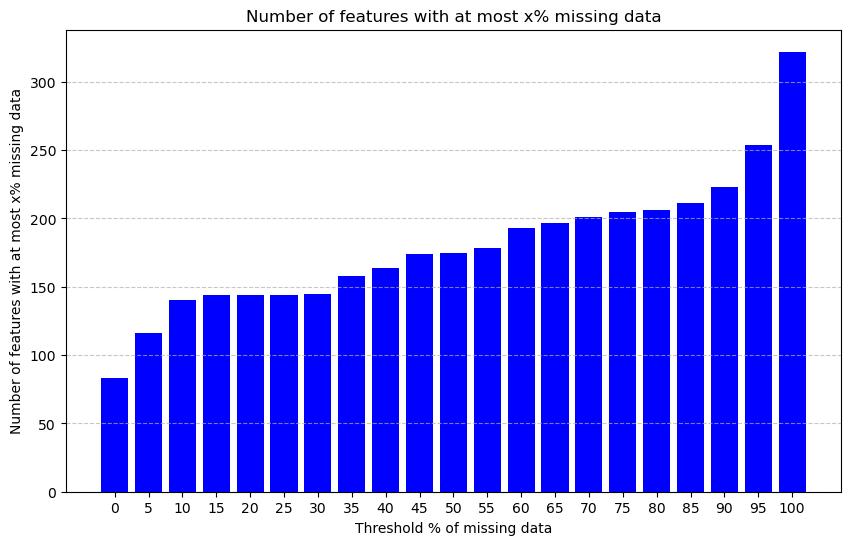

Post missingness X 
 (328135, 164)
Final shape: (328135, 75)
Remaining features: 75
kept features: ['_STATE', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXRACT11', 'EXEROFT1', 'EXERHMM1', 'EXRACT21', 'STRENGTH', 'SEATBELT', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTLANG', '_CHISPNC', '_PRACE1', '_RACE', '_RACEGR3', '_RACE_G1', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'DROCDY3_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PAFREQ1_', '_LMTACT1', '_LMTWRK1', '_LMTSCL1']
Post manual removal X 
 (328135, 75)
Post nan f

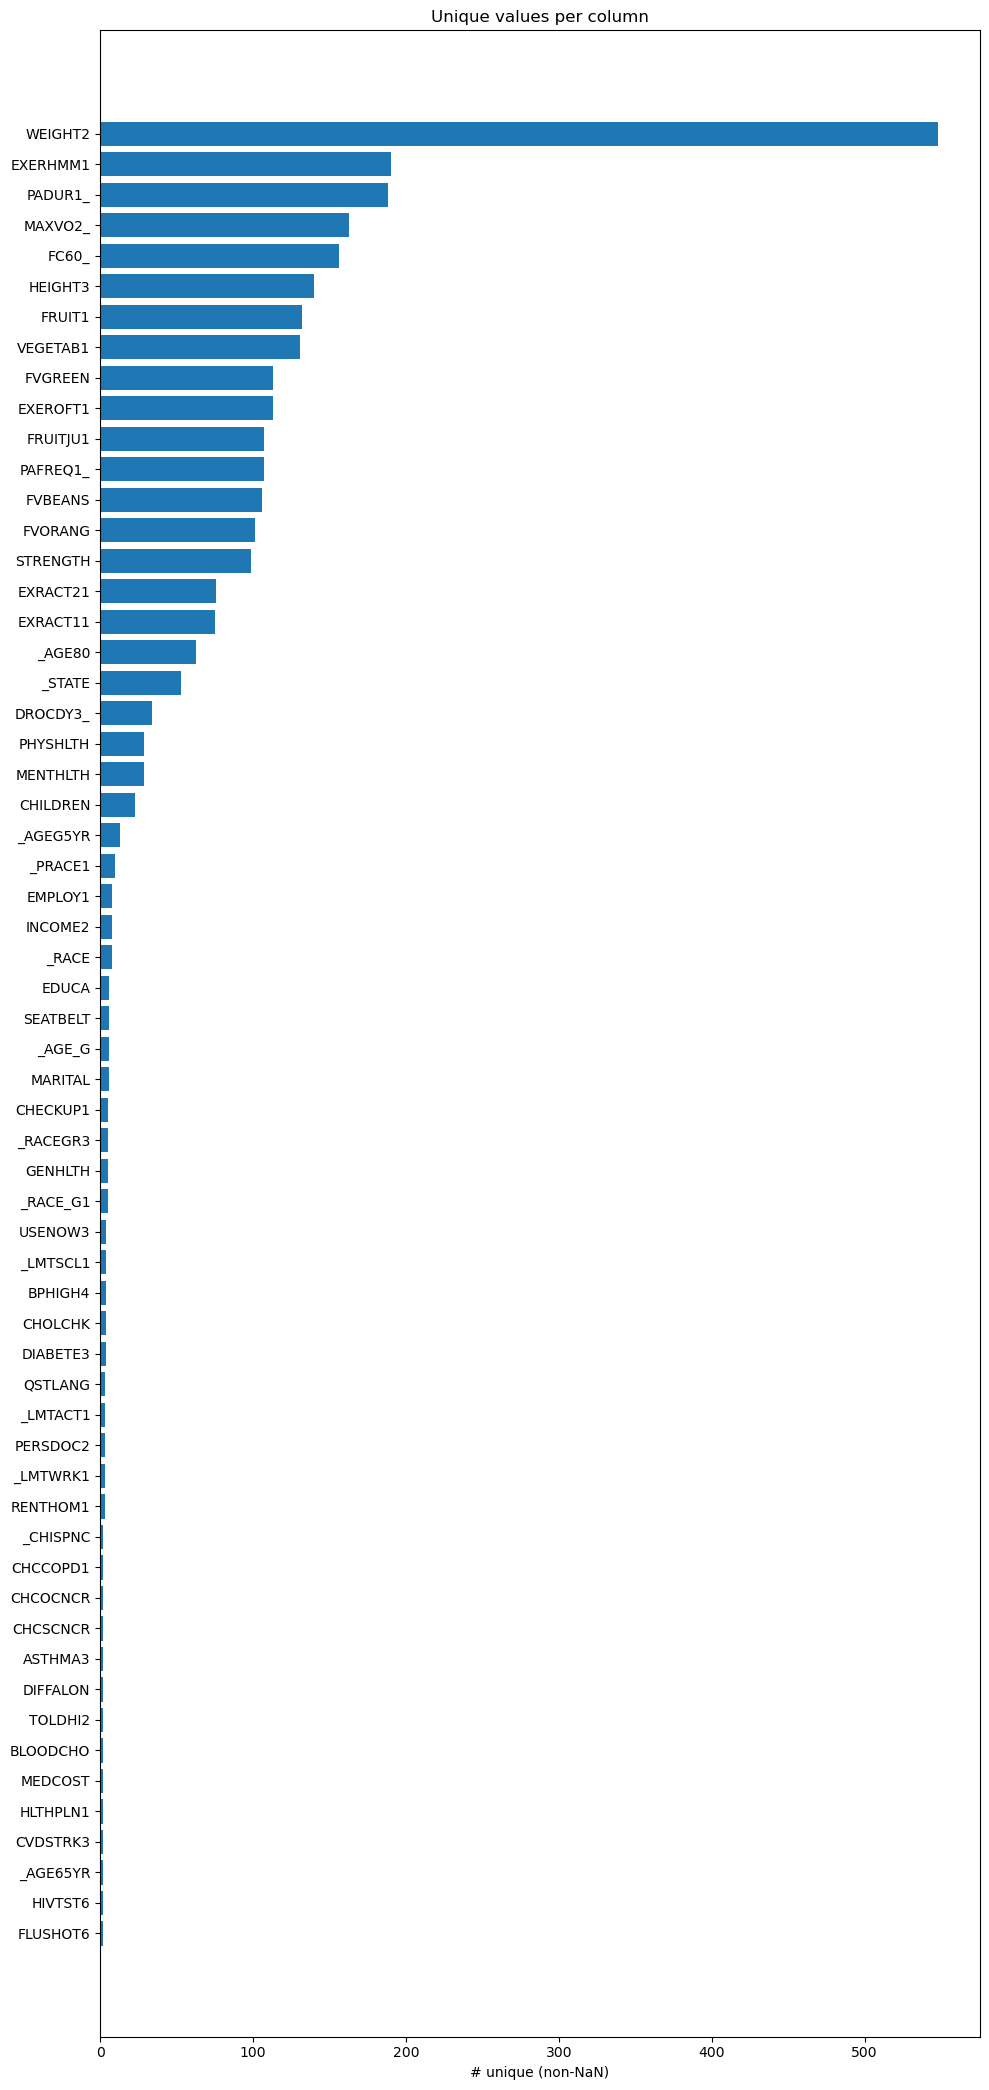

Column | #unique | %unique_of_nonmissing
WEIGHT2                   548      0.18%
EXERHMM1                  190      0.09%
PADUR1_                   188      0.09%
MAXVO2_                   163      0.05%
FC60_                     156      0.05%
HEIGHT3                   140      0.04%
FRUIT1                    132      0.04%
VEGETAB1                  131      0.04%
FVGREEN                   113      0.04%
EXEROFT1                  113      0.05%
FRUITJU1                  107      0.04%
PAFREQ1_                  107      0.06%
FVBEANS                   106      0.04%
FVORANG                   101      0.03%
STRENGTH                   99      0.03%
EXRACT21                   76      0.04%
EXRACT11                   75      0.03%
_AGE80                     63      0.02%
_STATE                     53      0.02%
DROCDY3_                   34      0.01%
PHYSHLTH                   29      0.01%
MENTHLTH                   29      0.01%
CHILDREN                   23      0.01%
_AGEG5YR        

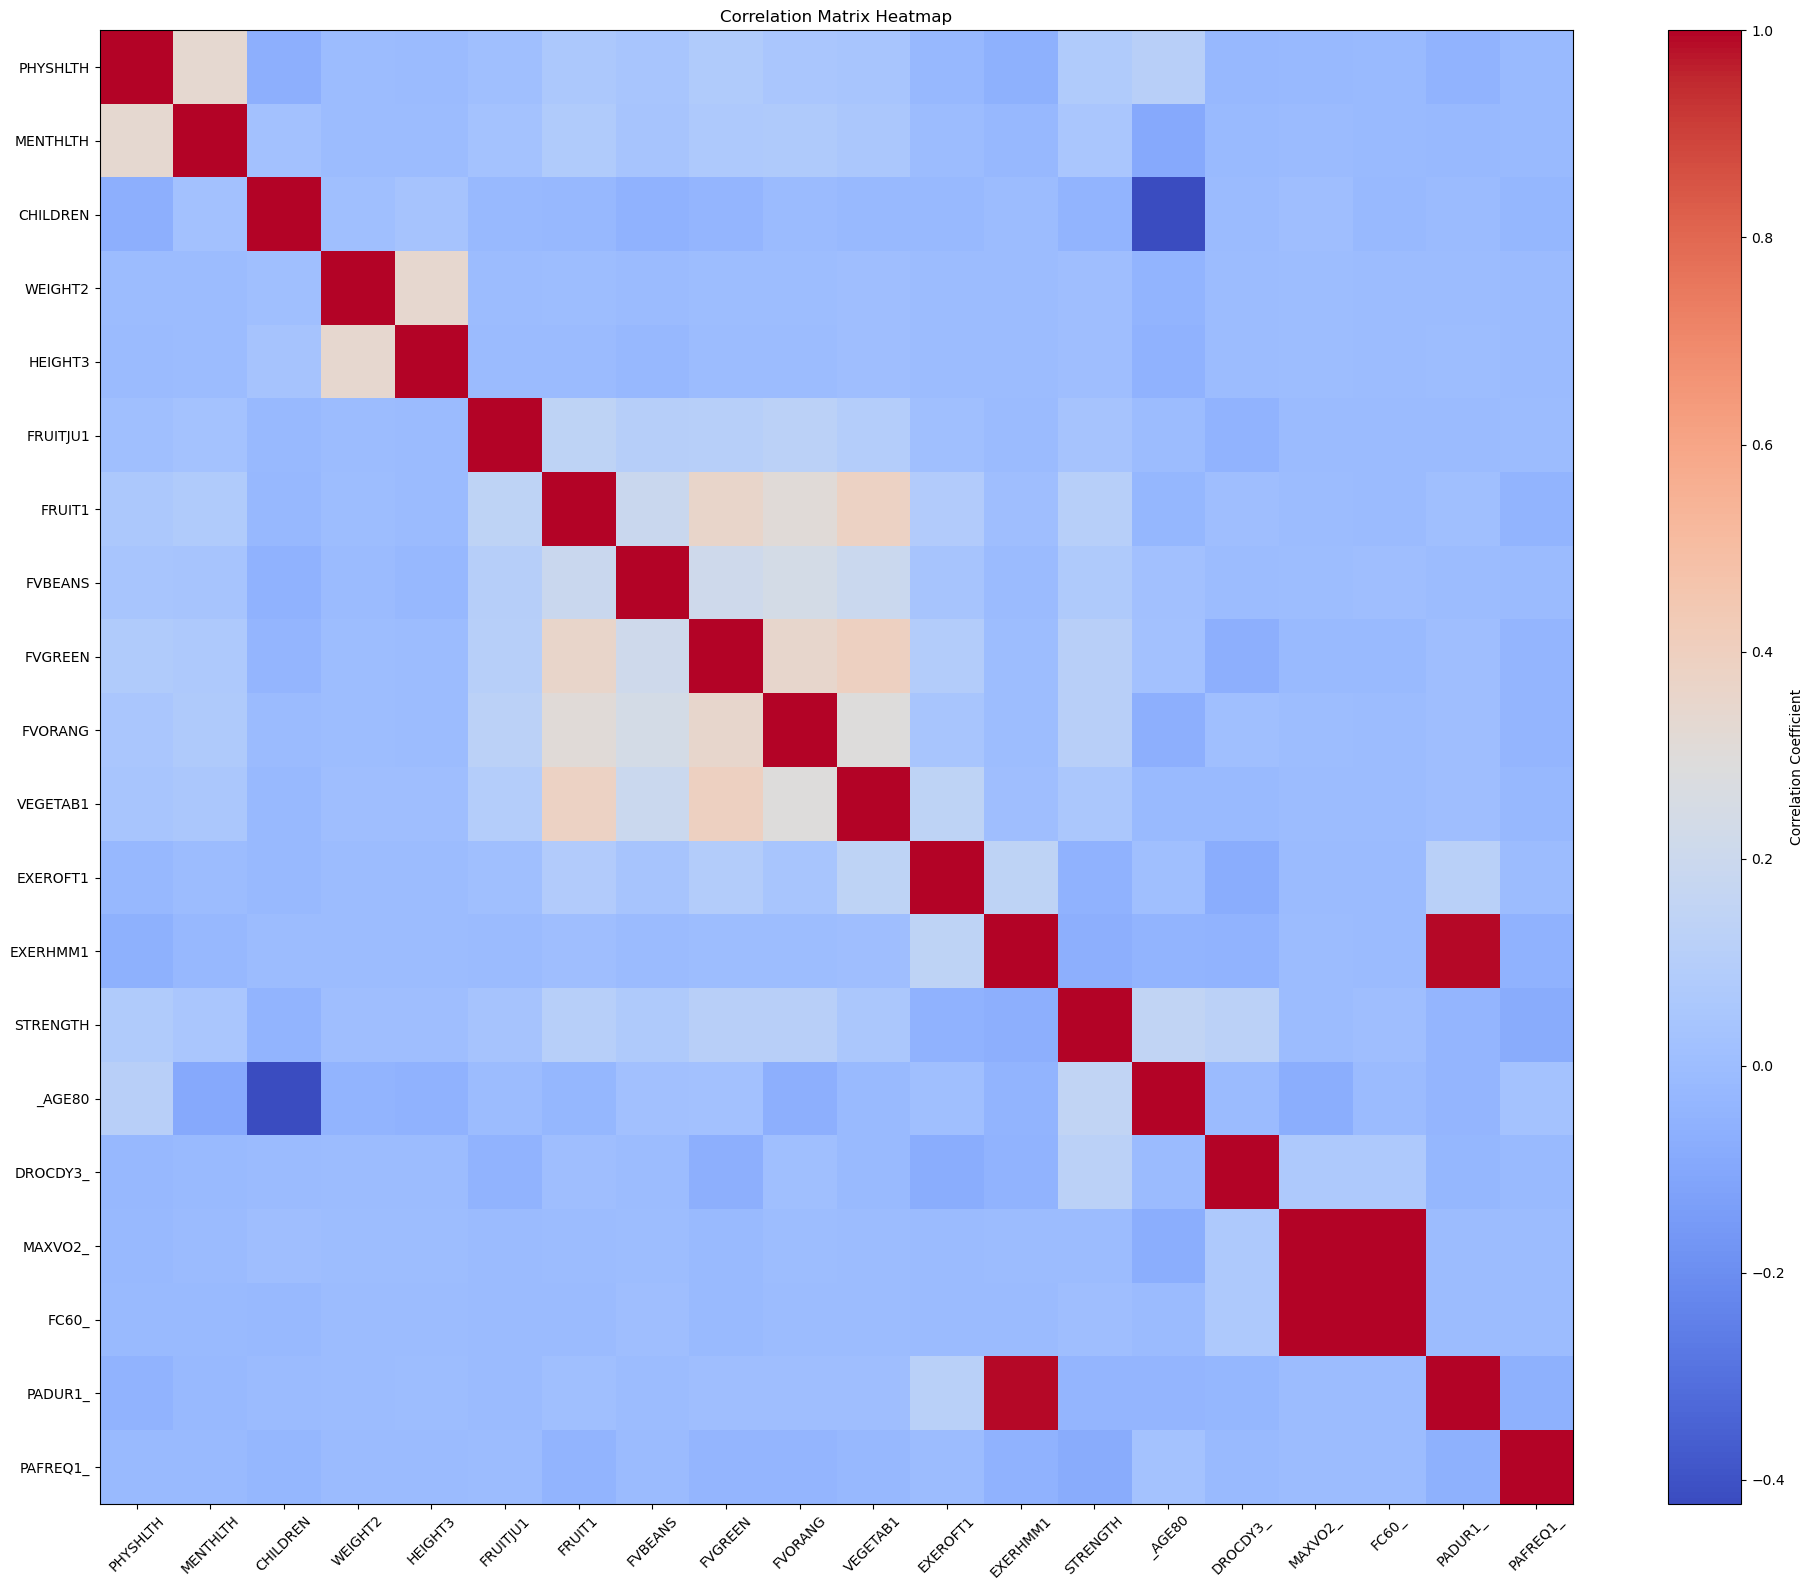

[high_corr_pairs:train] threshold=|r|>=0.90  total=2
  MAXVO2_ ~ FC60_   r=0.998 (+)
  EXERHMM1 ~ PADUR1_   r=0.993 (+)
Dropped: ['FC60_', 'PADUR1_']
New shape: (328135, 18)
Winsor [[  1.      5.      0.    ...   0.     26.91    2.   ]
 [  0.      0.      0.    ... 100.     28.65    3.   ]
 [  0.      0.      0.    ...  13.     23.95    3.   ]
 ...
 [  0.      1.      0.    ...   0.     22.84    4.   ]
 [  0.      0.      0.    ...   0.     36.35    0.467]
 [  0.      0.      1.    ...   0.     29.13    4.   ]] (328135, 18)
Standardised numeric X (328135, 18) 
 ['PHYSHLTH', 'MENTHLTH', 'CHILDREN', 'WEIGHT2', 'HEIGHT3', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXEROFT1', 'EXERHMM1', 'STRENGTH', '_AGE80', 'DROCDY3_', 'MAXVO2_', 'PAFREQ1_']
PCA X (328135, 15)
X final 
 (328135, 426)
[[ 0.          1.          0.         ... -0.42556711 -0.27598847
   0.38011578]
 [ 0.          1.          0.         ... -0.04697275 -0.36490516
  -0.1567738 ]
 [ 0.          1.   

In [ ]:
# Load data 
CSV_PATH = "data/dataset/x_train.csv"
X, feature_names = load_data(CSV_PATH)
print("Original X", "\n", X.shape)

# Missingness analysis 
# Removing columns with threshold % of missing values 
threshold_percent = 40
plot_missingness(X)
X_rem_missing, feature_names_rem_missing = compute_missing(X, feature_names,threshold_percent)
print("Post missingness X", "\n", X_rem_missing.shape)

# Manually removing columns 
# remove specific administrative/date/ID columns
admin_cols = ['Id', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR',
               'DISPCODE', 'SEQNO', '_PSU', 'QSTVER', 'MSCODE', '_STSTR', 'ALCDAY5', '_HISPANC', '_MRACE1']

# Columns that are calculated/derived from other columns in the list are removed. 
calculated_cols = [
    "_RFHLTH", "_HCVU651", "_RFHYPE5", "_CHOLCHK", "_RFCHOL",
    "_LTASTH1", "_CASTHM1", "_ASTHMS1", "_DRDXAR1",
    "HTIN4", "HTM4", "WTKG3", "_BMI5", "_BMI5CAT", "_RFBMI5",
    "_CHLDCNT", "_EDUCAG", "_INCOMG",
    "_SMOKER3", "_RFSMOK3","DRNKANY5",
    "_DRNKWEK", "_RFBING5", "_RFDRHV5",
    "FTJUDA1_", "FRUTDA1_", "BEANDAY_", "GRENDAY_", "ORNGDAY_", "VEGEDA1_",
    "_MISFRTN", "_MISVEGN", "_FRTRESP", "_VEGRESP",
    "_FRUTSUM", "_VEGESUM", "_FRTLT1", "_VEGLT1", "_FRT16", "_VEG23", "_FRUITEX", "_VEGETEX",
    "METVL11_", "ACTIN11_", "_MINAC11",
    "METVL21_", "ACTIN21_", "_MINAC21",
    "STRFREQ_", "PAMISS1_", "PAMIN11_", "PAMIN21_",
    "PA1MIN_", "PAVIG11_", "PAVIG21_", "PA1VIGM_",
    "_PACAT1", "_PAINDX1", "_PA150R2", "_PA300R2", "_PA30021",
    "_PASTRNG", "_PAREC1", "_PASTAE1",
    "_TOTINDA",
    "_RFSEAT2", "_RFSEAT3", "_AIDTST3","_RACEG21"
]

# Removing "weights assigned to each respondent" - hidden data in the dataset
weights = ["_STRWT","_RAWRAKE","_WT2RAKE","_DUALUSE","_DUALCOR","_LLCPWT"]

cols_to_remove = admin_cols+calculated_cols+weights
X_reduced, feature_names_reduced = remove_cols(X_rem_missing, feature_names_rem_missing, cols_to_remove)
print("Post manual removal X", "\n", X_reduced.shape)

# Default superset: covers DK/Refused across BRFSS 
DEFAULT_MISS = np.array([7, 9, 77, 99, 777, 999], dtype=float)

# Columns that need a DIFFERENT code set (override the default)
SPECIAL_MISS = {
    # only 9 means missing
    "_PRACE1": [9], "_MRACE1": [9], "_HISPANC": [9], "_RACE": [9],
    "_RACEGR3": [9], "_RACE_G1": [9], "EMPLOY1": [9], "USENOW3": [9],
    "MARITAL": [9], "EDUCA": [9], "QSTLANG": [9], "_AGE65YR": [9],
    "_AGE80": [9], "_AGE_G": [9],

    # activity type uses 77/99 only
    "EXRACT11": [77, 99], "EXRACT21": [77, 99],

    # children/income use 77/99
    "CHILDREN": [77, 99], "INCOME2": [77, 99],

    # special case: age bins (keep 1..13)
    "_AGEG5YR": [14], "_AGE65YR" : [3],
    
    # weight/height uses 7777,9999
    "WEIGHT2" : [7777,9999], "HEIGHT3": [7777,9999],"MAXVO2_": [7777, 9999],
    "FC60_":   [7777, 9999],
    
    # has its own list 
    "_STATE" : [7,77,99, 777, 999]
    
}

SPECIAL_TO_ZERO = {"PHYSHLTH": 88, "MENTHLTH": 88, "CHILDREN": 88}  # add others ONLY if codebook says 88 = None there

# Replacing default blank/missing/unk values with nan 
X_clean = clean_data(X_reduced,feature_names_reduced)
print("Post nan filling X", "\n", X_clean.shape)

# Imputation

# Plotting unique values per variable to help create algorithm to determine numerical vs categorical variables  
uniq_counts, prop_unique = plot_unique_counts(
    X_clean, feature_names_reduced,
    top_n=60,            # show top 60 most unique; set None to show all
    sort_desc=True,
    filename="unique_counts.png"
)

#Splitting dataset into columns that should be imputed with median (numeric) vs mode (categorical)
mode_cols, median_cols = impute_plan(
    X_clean, feature_names_reduced,
    abs_unique_cap=76,           # if #unique < abs_unique_cap  -> categorical (mode)
    rel_unique_cap=0.04,         # if %unique < rel_unique_cap  -> categorical (mode)
    singleton_ratio_thresh=0.60, # if ≥ threshold occur once    -> numeric (median)
    force_mode = {"_STATE","EXRACT11","EXRACT21"},             # e.g., {"_STATE","EXRACT11","EXRACT21"}
    force_median=None)
    
#Imputing dataset based on above created plan 
save_path = "data/dataset/impute_vals"
X_impute, fillers = impute(X_clean, feature_names_reduced,mode_cols, median_cols,save_path)
print("Post imputation X", "\n", X_impute.shape)

if perform_data_aug : 
    # NOTE: The 'median_cols' are the numeric columns defined during the imputation plan.
# We will only apply noise to these numeric columns.

    AUGMENTATION_FACTOR = 1 # Increase dataset size by 100% (X + 1*X_noise)
    NOISE_STD = 0.05

    # Using the unified function: augment_data_noise_stacking
    X_aug, feature_names_aug = augment_data_noise_stacking(
    X_impute,
    feature_names_reduced,
    median_cols,
    augmentation_factor=AUGMENTATION_FACTOR,
    noise_level=NOISE_STD
)

    # Replace the original imputed data with the augmented data for the rest of the pipeline
    X_impute = X_aug
    feature_names_reduced = feature_names_aug # names should be unchanged, but we keep the assignment for safety
    print("Post Augmentation X", "\n", X_impute.shape)

# Separate analysis for binary, categorical and numeric columsns 

# Split categorical columns into binary vs ordinal columns 
binary_cols, ohe_cols, constant_cols = identify_cat_cols(X_impute, feature_names_reduced, mode_cols, verbose=True)

# Binary 
X_bin_tr, binary_tr_cols  = build_binary_matrix(X_impute, feature_names_reduced, binary_cols)
print("Binary X", "\n", X_bin_tr.shape, "\n",binary_cols)

# One hot encoding for categorical 
if perform_one_hot:
    X_ohe_tr, ohe_tr_cols = fit_ohe_and_save(
        X_impute, feature_names_reduced, ohe_cols,
        save_path="data/dataset/onehot_model.npz",
        include_missing=True, use_other=True, min_count=1, drop_first=False, verbose=True
    )

else:
    X_ohe_tr, ohe_tr_cols, ohe_idx, missing = extract_columns_by_name(
    X_impute, feature_names_reduced, ohe_cols, strict=True
    )
print("OHE X", "\n", X_ohe_tr.shape,"\n",ohe_cols)

# Numeric analysis
X_numeric, num_names, num_idx, missing = extract_columns_by_name(
    X_impute, feature_names_reduced, median_cols, strict=True
)
print("Numeric X", "\n",X_numeric.shape, "\n",num_names)

# Perform correlation and plot heat map. Drop highly correlated features 
corr_matrix = plot_heat_map(X_numeric, num_names)
pairs = high_corr_pairs(corr_matrix, num_names, threshold=0.90, top_k=None, label="train")
X_pruned, names_pruned, dropped_names, drop_idx, keep_idx = drop_correlated_seconds(
    X_numeric, num_names, pairs, strict=False
)
print("Dropped:", dropped_names)
print("New shape:", X_pruned.shape)

# Winsorisation for outliers 
lo, hi = fit_winsor_caps(X_pruned, "data/dataset/winsor.npz", lower_q=0.01, upper_q=0.99)  # tweak 0.5/99.5 if needed
X_num_tr_clip = apply_winsor(X_pruned, lo, hi)
print("Winsor", X_num_tr_clip,X_num_tr_clip.shape)

# Standardisation 
std = fit_standardizer(X_num_tr_clip, "data/dataset/scaler_zscore")
X_std = transform_standardizer(X_num_tr_clip, std)

num_df = X_std
num_names = names_pruned

print("Standardised numeric X", X_std.shape, "\n", num_names)

# PCA and polynomial basis expansion
if perform_pca:
    
    num_df = pca_fit_and_save_train(
        X_std,
        variance_threshold=0.9,
        model_path="data/dataset/pca_train_model.npz",
        csv_path="data/dataset/pca_train_projection.csv", 
        row_id_name="idx"
    )
    
    num_names = make_pc_names(num_df.shape[1])
    print("PCA X", num_df.shape)

if perform_pbe:

    # After fitting the expansion
    num_df, num_names, phi_spec = fit_polynomial_features(
        num_df, feature_names=num_names, degree=2, include_bias=True, interaction_only=False
    )
    print("PBE", num_df, num_df.shape)
    # Save
    save_poly_spec(phi_spec, num_names, path="data/dataset/poly_spec.npz")

# Final training dataset 
# Combine binary, ordinal and PCA numeric data to generate final cleaned training set 
X_final, final_names = concat_design(num_df, num_names, X_bin_tr, binary_tr_cols, X_ohe_tr, ohe_tr_cols)
print("X final","\n",X_final.shape)
print(X_final)

np.savetxt(train_file_name,X_final,delimiter=",",header=",".join(final_names),comments="")

### Apply same data preprocessing to testing set (takes 1 min)

In [ ]:
# Load data 
CSV_PATH = "data/dataset/x_test.csv"
X_test, feature_names_test = load_data(CSV_PATH)

# Matching Manual analysis in training to testing set 
X_test_removed, features_test_reduced, missing, extra = align_test_to_train(
    X_test, feature_names_test, feature_names_reduced, fill_value=np.nan, strict=False
)
print("Test features", features_test_reduced)

# Replacing default blank/missing/unk values with nan 
X_test_clean = clean_data(X_test_removed,features_test_reduced)
print("Post nan filling X", "\n", X_clean.shape)

# Imputation using saved imputer 
imputer_path = "data/dataset/impute_vals.npz"
X_test_impute = apply_imputer_to_test(X_test_clean, features_test_reduced, imputer_path)
print("Imputed",X_test_impute.shape)

# Data Augmentation 

# NOTE: Variables AUGMENTATION_FACTOR and NOISE_STD MUST be defined and set
# to 1 and 0.05 respectively, matching the training script.
if perform_data_aug : 
# Using the unified function: augment_data_noise_stacking
    X_test_aug, features_test_reduced = augment_data_noise_stacking(
    X_test_impute,
    features_test_reduced,
    median_cols,
    augmentation_factor=AUGMENTATION_FACTOR, # Uses the same factor
    noise_level=NOISE_STD                     # Uses the same noise level
        )

    # Replace the original imputed data with the augmented data for the rest of the pipeline
    X_test_impute = X_test_aug
    print("Post Augmentation X_test", "\n", X_test_impute.shape)

# Separate analysis for binary, categorical and numeric columsns 

# Binary 
X_test_bin, bin_test_names  = build_binary_matrix(X_test_impute, features_test_reduced, binary_cols)
print("Binary",X_test_bin)

# One hot encoding on categoricals using saved encoder 
if perform_one_hot:
    X_test_ohe, ohe_test_names= apply_saved_ohe(X_test_impute, features_test_reduced, load_path="data/dataset/onehot_model.npz", strict=True)
else:
    X_test_ohe, ohe_test_names, ohe_idx, missing = extract_columns_by_name(
    X_test_impute, features_test_reduced, ohe_cols, strict=True )    
print("OHE",X_test_ohe)

# Numeric analysis  
X_test_numeric, test_num_names, test_num_idx, missing = extract_columns_by_name(X_test_impute, features_test_reduced, median_cols, strict=True)

# Dropping same correlated features as training 
X_test_corr, feature_names_corr_reduced, dropped_names, drop_idx, keep_idx = drop_correlated_seconds(X_test_numeric, test_num_names, pairs, strict=False)
print("Numeric features left post correlation", X_test_corr.shape)

# Winsorisation using saved thresholds 
lo, hi  = load_winsor_caps("data/dataset/winsor.npz")
X_num_te_clip = apply_winsor(X_test_corr, lo, hi)
print("Winsor", X_num_te_clip,X_num_te_clip.shape)

# Standardisation using saved standardiser  
standardiser = load_standardizer(path="data/dataset/scaler_zscore.npz")
X_test_std = transform_standardizer(X_test_corr, standardiser)
print("X after standardisation",X_std.shape)

X_test_numeric = X_test_std
test_num_names = feature_names_corr_reduced

# PCA and polynomial basis expansion
if perform_pca:
    X_test_numeric = pca_transform(X_test_std, model_path="data/dataset/pca_train_model.npz")
    test_num_names = make_pc_names(X_test_numeric.shape[1], prefix="PC")
    print("PCA", X_test_numeric, X_test_numeric.shape)

if perform_pbe:
    phi_spec_loaded, test_num_names = load_poly_spec("data/dataset/poly_spec.npz")
    X_test_numeric = transform_polynomial_features(X_test_numeric, phi_spec_loaded)
    print("PBE", X_test_numeric, X_test_numeric.shape)
    
# Final testing dataset 
X_test_final, final_test_names  = concat_design(X_test_numeric, test_num_names, X_test_bin, bin_test_names, X_test_ohe, ohe_test_names)
np.savetxt(test_file_name,X_test_final,delimiter=",",header=",".join(final_test_names),comments="")
print(X_test_final.shape)

Test features ['_STATE', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'USENOW3', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN', 'FVORANG', 'VEGETAB1', 'EXERANY2', 'EXRACT11', 'EXEROFT1', 'EXERHMM1', 'EXRACT21', 'STRENGTH', 'SEATBELT', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTLANG', '_CHISPNC', '_PRACE1', '_RACE', '_RACEGR3', '_RACE_G1', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G', 'DROCDY3_', 'MAXVO2_', 'FC60_', 'PADUR1_', 'PAFREQ1_', '_LMTACT1', '_LMTWRK1', '_LMTSCL1']
Post nan filling X 
 (328135, 75)
Imputed (109379, 75)
Binary [[0. 1. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 1.